In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import cv2

from skimage import data, io, filters, color, exposure

In [2]:
from tensorflow.keras.applications import DenseNet121

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Function to load and operate on the content and style images
def get_data(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [6]:
content_image = load_img('/content/drive/MyDrive/MSiA432_Project/000002.jpg')
style_image = load_img('/content/drive/MyDrive/MSiA432_Project/starry_nights.jpeg')

Text(0.5, 1.0, 'Style Image')

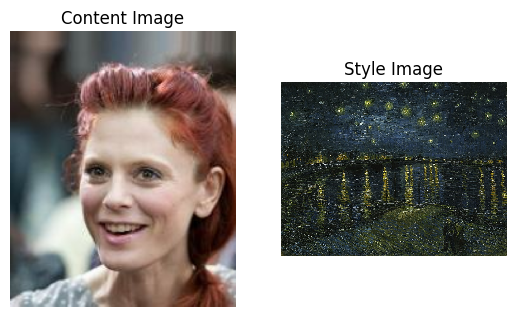

In [7]:
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(content_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Content Image')


plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(style_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Style Image')

In [8]:
dense_net = DenseNet121(include_top=False, weights='imagenet')

29084464/29084464 [==============================] - 0s 0us/step


In [9]:
for layer in dense_net.layers:
  print(layer.name)

input_1
zero_padding2d
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_1
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3_b

In [10]:
content_layers = ['conv5_block9_1_conv'] 

layer_name = ['1', '2', '3', '4']
style_layers = ['conv2_block1_1_conv', 'conv3_block12_1_conv', 'conv4_block23_2_conv', 'conv5_block8_1_conv']

# for name in layer_name:
#   style_layers.append('conv' + name + '_' + 'block' + name + '_1_conv')
print(style_layers)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

['conv2_block1_1_conv', 'conv3_block12_1_conv', 'conv4_block23_2_conv', 'conv5_block8_1_conv']


In [11]:
def densenet_layers(layer_names):
  """ Creates a efficient nate model that returns a list of intermediate output values."""
  # Load our model. Load pretrained Dense, trained on ImageNet data
  dense_net = DenseNet121(include_top=False, weights='imagenet')
  dense_net.trainable = False

  outputs = [dense_net.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([dense_net.input], outputs)
  return model

In [12]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [13]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.effnet = densenet_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.effnet.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    #preprocessed_input = preprocess_input(inputs)
    outputs = self.effnet(inputs)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [14]:
## Getting the targets
extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [15]:
## Generated image
image = tf.Variable(content_image)

In [16]:
# Since this is a float image, define a function to keep the pixel values between 0 and 1:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1 #1e-2
content_weight=1e-4

In [18]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [19]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [20]:
## Training
epochs = 2000

for i in range(epochs):
  if(i % 100 == 0):
    print(f'Epoch {i}')
  train_step(image)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900


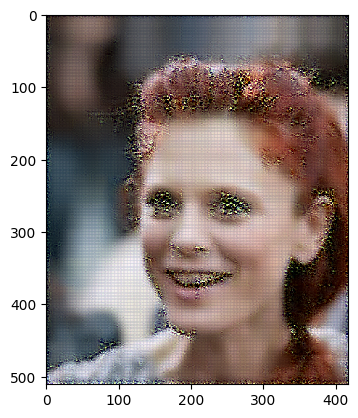

In [21]:
## DenseNet with tensor load
plt.imshow(image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')